# Modeling Explanation (READ ONLY. DO NOT RUN CELLS.)

This notebook goes into depth about how we did our modeling. This notebook required a lot of trial and error. Due to this, many datasets that this notebook loads no longer exists. This notebook only serves to explain how things work.

### Install and load needed packages

In [1]:
install.packages('plm')


also installing the dependencies ‘miscTools’, ‘rbibutils’, ‘bdsmatrix’, ‘collapse’, ‘sandwich’, ‘maxLik’, ‘Rdpack’, ‘Formula’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library(plm)
library('dplyr')
library('tidyverse')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plm’:

    between, lag, lead

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ readr   1.3.1
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ ggplot2 3.2.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between() masks plm::between()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks plm::lag(), stats::lag()
✖ dplyr::lead()    masks plm::lead()


### Load the complete dataframe. This dataframe has null values replaced with estimated values. Continent, region, and ISO3 code are also appended for easy access

In [3]:
completeDF <- read.csv("../../M2/carpentry/completeDF.csv")
head(completeDF)

CountryName,Year,SPURBGROW,SPPOPAG25FEIN,SPPOPAG25MAIN,SPPOPDPND,SPPOPDPNDOL,SPPOPDPNDYG,SPPOPGROW,SPPOPTOTL,⋯,NYGDPFCSTKD,NYGDPFCSTKN,NYTAXNINDCD,SEPRMENRRFE,SEENRPRIMFMZS,SEPRMENRRMA,NVINDMANFKDZG,Continent,Region1,ISO3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
Albania,1990,2.5430425,29833,30896,61.99491,8.901594,53.09332,1.7990856,3286542,⋯,4687983945,556155415389,456523006,99.68872,1.00459,99.23334,-1.330062,Europe,Southern Europe,ALB
Albania,1991,0.1410606,28894,29109,62.71541,9.191396,53.52401,-0.6028097,3266790,⋯,3484062971,413329164899,559041634,101.44180,1.00398,101.03975,4.437151,Europe,Southern Europe,ALB
Albania,1992,0.8784304,27689,26863,63.31198,9.516996,53.79498,-0.6064347,3247039,⋯,3241801595,384588670499,559041634,100.39709,1.01642,98.77510,4.437151,Europe,Southern Europe,ALB
Albania,1993,0.8555350,26544,24681,63.74301,9.867033,53.87598,-0.6101658,3227287,⋯,3599531754,427027716199,721980467,100.27136,1.03497,96.88289,5.424634,Europe,Southern Europe,ALB
Albania,1994,0.8437257,25748,23079,64.07723,10.223010,53.85422,-0.6138805,3207536,⋯,4012270326,475992643298,1058320920,100.87940,0.98764,102.14209,8.645841,Europe,Southern Europe,ALB
Albania,1995,0.8241713,25291,22172,64.40525,10.575354,53.82990,-0.6177037,3187784,⋯,4206551264,499041014898,1154513774,102.34688,0.96867,105.65663,6.642161,Europe,Southern Europe,ALB


### Cutting the completeDF to 1990+ and selecting countries to be included. These values are assigned to the contdf variable so as to not require a reload of the completeDF if you want to change operating areas. We then reconstruct the dataframe into a scaled version while rearranging the contintent, ISO3, and region information to the front for greater visibility.

In [4]:
contdf=completeDF[
    completeDF['Year']>=1990 
    
    
    & (completeDF['Continent']=='Europe') 
    & !(completeDF['CountryName']=='Moldova' |
       completeDF['CountryName']=='Bulgaria' | 
       completeDF['CountryName']=='Ukraine' |
       completeDF['CountryName']=='Belarus' |
       completeDF['CountryName']=='Albania' |
       completeDF['CountryName']=='Romania' |
       completeDF['CountryName']=='Poland' )
    
#   & (completeDF['Continent']=='Africa')    
#   & !(completeDF['CountryName']=='Mauritius' 
#     |    completeDF['CountryName']=='Tunisia' 
#     |    completeDF['CountryName']=='Morocco' 
#     |    completeDF['CountryName']=='Algeria'
#     |    completeDF['CountryName']=='Botswana'
#     |    completeDF['CountryName']=='South Africa'
#     |    completeDF['CountryName']=='Cabo Verde')
    ,]
#Scale DF
center=T
scaleddf <- cbind(cbind(contdf[1:2], contdf[599:601]), scale(contdf[3:(ncol(contdf)-3)], center=center))


### Since countries are distinct, we need the fixed effects for each to be established. For that reason, we used a train/test breakdown of 1990-2010 for training and 2011-2019 for testing.

In [5]:
train=scaleddf[scaleddf['Year']<=2010,]
test=scaleddf[scaleddf['Year']>2010,]

### Based on the nature of the modeling that we're performing, effects are evaluated on a per-country basis and fixed-effect values are established. These values provide the baseline upon which calculated coefficients are applied. Since we're using rate data for most of our research, the variables don't have the momentum provided to satisfy the time component from year to year. For example, population this year is going to be similar to population last year simply because most of the population persists but adolescent fertility rate, in contrast, may be comparable to last year's fertility rate but is not bound by it - it could double or halve in ways a population can't. For this reason, we were not able to incorporate time and individual effects into our model. As shown below, this is a fixed plm with only individual effects.

### The first model is used for simply identifying generic trends and groupings. Because the variables can model either their own impacts or any variables that highly correlate, these components can capture the trends of a population's birthrate by simply knowing the established trends and their cohort size. Effectively, this is a repeated instance of [birth rate for x cohort]*[population of x cohort]=birthrate and, in this way, probably resembles a random effects model captured in a fixed-effects wrapper at this stage.

In [6]:
# #Pop Structure Alone
dv='SPDYNCBRTIN'
ivs="SPPOP0509FE5Y + SPPOP1014FE5Y + SPPOP1519FE5Y + SPPOP2024FE5Y + SPPOP2529FE5Y + SPPOP3034FE5Y + SPPOP3539FE5Y + SPPOP4044FE5Y + SPPOP4549FE5Y + SPPOP5054FE5Y + SPPOP5559FE5Y + SPPOP6064FE5Y + SPPOP65UPFEZS"
mod=plm(eval(paste(dv, "~", ivs)), data=train, index=c('CountryName', 'Year'), method='fixed', effect='individual')
#mod=plm("SPDYNCBRTIN ~ SPDYNTFRTIN+SPADOTFRT*NYGDPMKTPKDZG*NYGDPPCAPKDZG*NYGDPTOTLRTZS*EGELCACCSURZS*EGELCFOSLZS*SPDYNLE00FEIN", data=scaleddf, index=c('CountryName', 'Year'), method='fixed')
 summary(mod)


Oneway (individual) effect Within Model

Call:
plm(formula = eval(paste(dv, "~", ivs)), data = train, effect = "individual", 
    index = c("CountryName", "Year"), method = "fixed")

Balanced Panel: n = 24, T = 21, N = 504

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-1.1858620 -0.1601492 -0.0021217  0.1451787  1.2090031 

Coefficients:
               Estimate Std. Error t-value  Pr(>|t|)    
SPPOP0509FE5Y -1.661522   0.075278 -22.072 < 2.2e-16 ***
SPPOP1014FE5Y -0.956341   0.054364 -17.591 < 2.2e-16 ***
SPPOP1519FE5Y -1.455233   0.091466 -15.910 < 2.2e-16 ***
SPPOP2024FE5Y -0.998189   0.061260 -16.294 < 2.2e-16 ***
SPPOP2529FE5Y -0.821997   0.060863 -13.506 < 2.2e-16 ***
SPPOP3034FE5Y -0.944623   0.053032 -17.812 < 2.2e-16 ***
SPPOP3539FE5Y -0.752337   0.047976 -15.681 < 2.2e-16 ***
SPPOP4044FE5Y -0.681860   0.034956 -19.506 < 2.2e-16 ***
SPPOP4549FE5Y -0.792634   0.037415 -21.185 < 2.2e-16 ***
SPPOP5054FE5Y -0.974648   0.038127 -25.564 < 2.2e-16 ***
SPPOP5559FE

### Individual continents offer more resolution than countries but, within them, are also regions of subpopulations with unique trends and characteristics. For this reason, certain countries are excluded in the continent dataframe creation box. For those included, they will have a distinct list of variables that can be used to calculate their uniquely constructed birthrate. Each continent has a box below where their model is being constructed.

In [63]:
# #North America
# dv='SPDYNCBRTIN'
# ivs="SESECENRLGCFEZS + SHMMRLEVE + SPURBGROW + NVSRVTOTLZS + ITNETUSERZS + BMKLTDINVWDGDZS + SPPOP0509FE5Y + SPPOP1014FE5Y + SPPOP1519FE5Y + SPPOP2024FE5Y + SPPOP2529FE5Y + SPPOP3034FE5Y + SPPOP3539FE5Y*SPADOTFRT + SPPOP4044FE5Y + SPPOP4549FE5Y + SPPOP5054FE5Y + SPPOP5559FE5Y + SPPOP6064FE5Y + SPPOP65UPFEZS*SPADOTFRT"
# mod=plm(eval(paste(dv, "~", ivs)), data=train, index=c('CountryName', 'Year'), method='fixed', effect='individual')
# #mod=plm("SPDYNCBRTIN ~ SPDYNTFRTIN+SPADOTFRT*NYGDPMKTPKDZG*NYGDPPCAPKDZG*NYGDPTOTLRTZS*EGELCACCSURZS*EGELCFOSLZS*SPDYNLE00FEIN", data=scaleddf, index=c('CountryName', 'Year'), method='fixed')
# summary(mod)


In [64]:
# #South America
# dv='SPDYNCBRTIN'
# ivs="SESECENRLGCFEZS + SHMMRLEVE + SPURBGROW + NVSRVTOTLZS + ITNETUSERZS + BMKLTDINVWDGDZS + SPPOP0509FE5Y + SPPOP1014FE5Y + SPPOP1519FE5Y + SPPOP2024FE5Y + SPPOP2529FE5Y + SPPOP3034FE5Y + SPPOP3539FE5Y*SPADOTFRT + SPPOP4044FE5Y + SPPOP4549FE5Y + SPPOP5054FE5Y + SPPOP5559FE5Y + SPPOP6064FE5Y + SPPOP65UPFEZS*SPADOTFRT"
# mod=plm(eval(paste(dv, "~", ivs)), data=train, index=c('CountryName', 'Year'), method='fixed', effect='individual')
# #mod=plm("SPDYNCBRTIN ~ SPDYNTFRTIN+SPADOTFRT*NYGDPMKTPKDZG*NYGDPPCAPKDZG*NYGDPTOTLRTZS*EGELCACCSURZS*EGELCFOSLZS*SPDYNLE00FEIN", data=scaleddf, index=c('CountryName', 'Year'), method='fixed')
# summary(mod)


In [66]:
# # Run without Mauritius, Tunisia, Morocco, Algeria, Botswana, South Africa, or Cabo Verdo
# #Africa
# dv='SPDYNCBRTIN'
# iv=c(
#     'SESECENRR',   #- This is essential to the model's success but is currently removed from the dataframe. 
# 'SESECENRLGCFEZS',
'SPPOP0509FE5Y',
# 'SPPOP5559MA',
'SPPOP65UPMAZS',
'SPPOP65UPTOZS',
'SPPOP0509MA5Y',
'SPDYNIMRTFEIN',
'SPADOTFRT',
# 'SPPOPAG01MAIN',
# 'SPPOPAG03FEIN',
'SPDYNTO65MAZS',
'SPPOP1564FEZS',
'SPPOP1014MA5Y',
'SPDYNLE00MAIN',
'SPPOP5054FE5Y',
'SPPOP4044MA5Y',
# 'SPPOPGROW',
'SPURBGROW',
'SESECDURS',
'ITCELSETSP2',
'NYADJDNGYGNZS',
'NECONGOVTZS',
# 'SHSTAOB18FEZS',
# 'SHSTAOB18MAZS',
# 'NVAGRTOTLZS',
'SHIMMMEAS',
# 'EGUSEELECKHPC',
'AGYLDCRELKG',
# 'SPPOP7074FE5Y',
'ENPOPDNST',
# 'NVINDMANFZS',
'NVAGRTOTLCD',
'MSMILXPNDGDZS'
# 'SPPOP4549FE5Y',
# 'TMVALMRCHHIZS' 
# 'TXVALMANFZSUN'
#     )
# ivstring <- gsub(",", " +", toString(iv))

# mod=plm(eval(paste(dv, "~", ivstring)), data=train, index=c('CountryName', 'Year'), method='fixed', effect='individual')
# #mod=plm("SPDYNCBRTIN ~ SPDYNTFRTIN+SPADOTFRT*NYGDPMKTPKDZG*NYGDPPCAPKDZG*NYGDPTOTLRTZS*EGELCACCSURZS*EGELCFOSLZS*SPDYNLE00FEIN", data=scaleddf, index=c('CountryName', 'Year'), method='fixed')
# summary(mod)


In [70]:
# # Southern Europe # Just doing some testing
# #Europe
# dv='SPDYNCBRTIN'
# iv=c("SHDYNNMRT", 
#      "SPPOP2529MA5Y", 
#      "SHDYNMORT", 
# #      "SPPOP1564TOZS", 
#      "SPPOP4044FE", 
#      "SPPOP6569MA", 
#      "SPPOP4549MA5Y", 
#      "MSMILXPNDGDZS", 
#      "TMVALMRCHR3ZS", 
#      "AGLNDCROPZS", 
#      "MSMILTOTLTFZS", 
#      "BXGSRINSFZS", 
#      "NEDABDEFLZS", 
#      "ENATMCO2EGFKT", 
# #      "SEENRPRIMFMZS"
#     )
# ivstring <- gsub(",", " +", toString(iv))
# mod=plm(eval(paste(dv, "~", ivstring)), data=train, index=c('CountryName', 'Year'), method='fixed', effect='individual')
# #mod=plm("SPDYNCBRTIN ~ SPDYNTFRTIN+SPADOTFRT*NYGDPMKTPKDZG*NYGDPPCAPKDZG*NYGDPTOTLRTZS*EGELCACCSURZS*EGELCFOSLZS*SPDYNLE00FEIN", data=scaleddf, index=c('CountryName', 'Year'), method='fixed')
# summary(mod)


Oneway (individual) effect Within Model

Call:
plm(formula = eval(paste(dv, "~", ivstring)), data = train, effect = "individual", 
    index = c("CountryName", "Year"), method = "fixed")

Balanced Panel: n = 8, T = 21, N = 168

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.2569049 -0.0712271  0.0015933  0.0627435  0.3609622 

Coefficients:
               Estimate Std. Error  t-value  Pr(>|t|)    
SHDYNNMRT     -1.058960   0.056012 -18.9060 < 2.2e-16 ***
SPPOP2529MA5Y  0.093441   0.023709   3.9412 0.0001250 ***
SHDYNMORT      1.720917   0.046679  36.8671 < 2.2e-16 ***
SPPOP4044FE    0.691142   0.171451   4.0311 8.879e-05 ***
SPPOP6569MA   -0.993459   0.191908  -5.1767 7.297e-07 ***
SPPOP4549MA5Y -0.148270   0.021394  -6.9304 1.226e-10 ***
MSMILXPNDGDZS  0.071032   0.012162   5.8403 3.218e-08 ***
TMVALMRCHR3ZS  0.089776   0.029431   3.0504 0.0027120 ** 
AGLNDCROPZS    0.392304   0.046537   8.4300 2.931e-14 ***
MSMILTOTLTFZS  0.074374   0.012169   6.1117 8.431e-09 

### Having a variable in your model that is missing from your dataframe will often crash your kernel. If you want to check one, check it here. If you want to check a list, you can feed it into a corr diagram where you can comment out large swaths to see if any are missing. Move this checker to wherever you're building a model for maximum accessibility.

In [173]:
head(train['SGLOCLIVEEQ'])

,SGLOCLIVEEQ
,<dbl>
151,NaN
152,NaN
153,NaN
154,NaN
155,NaN
156,NaN


### Breaking up the model into an iv cell and a model cell could allow for a recursive process where the model is culled one by one. 

In [177]:
iv=c("SPURBGROW", 
#      "SPPOPDPNDOL", ----Never let this in!
     "SHDYNNMRT", 
     "SPPOP2529MA5Y", 
     "SPDYNIMRTMAIN", 
     "SHDYNMORT", 
     "SPPOP1014MA5Y", 
     "SPPOP1519FE5Y", 
     "SPPOP1519MA5Y", 
#      "SPPOP1564TOZS", 
     "SPPOP0014TO", 
     "SPPOP6569FE", 
     "SPPOP7074MA5Y", 
     "ITMLTMAIN",  
     "SLEMPTOTLSPZS", 
     "SLFAMWORKMAZS", 
     "EGFECRNEWZS", 
     "TMVALMRCHALZS", 
     "FPCPITOTL", 
     
     "NVSRVTOTLZS", 
     "TMVALMRCHXDWD", 
     "BMGSRTRANZS", 
     "NEGDIFTOTKDZG",
     'SPPOP0004MA5Y',
#  'SGLOCLIVEEQ',
 'NYGDPFRSTRTZS',
 'ENATMCO2EPC',
 'SLTLFCACTMAZS',
 'SGLAWINDX',
 'TXVALMRCHR6ZS',
 'SEENRPRIMFMZS',
"SHHTNTRETFEZS",
# 'SESECENRLGCFEZS'-
'SPPOP0509FE5Y',
'SPPOP5559MA',
'SPPOP65UPMAZS',
# 'SPPOP65UPTOZS',
     
'SPPOP0509MA5Y',
'SPDYNIMRTFEIN',
'SPADOTFRT',
'SPPOPAG01MAIN',
'SPPOPAG03FEIN',
'SPDYNTO65MAZS',
'SPPOP1564FEZS',
'SPDYNLE00MAIN',
'SPPOP5054FE5Y',
'SPPOP4044MA5Y',
 'SESECDURS',
'ITCELSETSP2',
'NYADJDNGYGNZS',
'NECONGOVTZS',
'SHSTAOB18FEZS',
     
'SHSTAOB18MAZS',
'NVAGRTOTLZS',
'SHIMMMEAS',
# 'EGUSEELECKHPC'-
'AGYLDCRELKG',
'SPPOP7074FE5Y',
'ENPOPDNST',
'NVINDMANFZS',
'NVAGRTOTLCD',
'MSMILXPNDGDZS',
'SPPOP4549FE5Y',
'TMVALMRCHHIZS'
# 'TXVALMANFZSUN'-
    )

In [178]:
#First list from Jon
#Europe
dv='SPDYNCBRTIN'

ivstring <- gsub(",", " +", toString(iv))
mod=plm(eval(paste(dv, "~", ivstring)), data=train, index=c('CountryName', 'Year'), method='fixed', effect='individual')
#mod=plm("SPDYNCBRTIN ~ SPDYNTFRTIN+SPADOTFRT*NYGDPMKTPKDZG*NYGDPPCAPKDZG*NYGDPTOTLRTZS*EGELCACCSURZS*EGELCFOSLZS*SPDYNLE00FEIN", data=scaleddf, index=c('CountryName', 'Year'), method='fixed')
#summary(mod)


Oneway (individual) effect Within Model

Call:
plm(formula = eval(paste(dv, "~", ivstring)), data = train, effect = "individual", 
    index = c("CountryName", "Year"), method = "fixed")

Balanced Panel: n = 24, T = 21, N = 504

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.74921880 -0.12061313 -0.00049044  0.11143643  0.67635658 

Coefficients:
                 Estimate  Std. Error t-value  Pr(>|t|)    
SPURBGROW      0.12279574  0.02195746  5.5924 4.030e-08 ***
SHDYNNMRT     -0.39943971  0.12314346 -3.2437 0.0012737 ** 
SPPOP2529MA5Y  0.01232383  0.03808605  0.3236 0.7464174    
SPDYNIMRTMAIN -0.46743021  0.72636135 -0.6435 0.5202344    
SHDYNMORT      1.08101416  0.49871842  2.1676 0.0307488 *  
SPPOP1014MA5Y  0.12195576  0.08208035  1.4858 0.1380762    
SPPOP1519FE5Y -1.08457985  0.31836934 -3.4067 0.0007207 ***
SPPOP1519MA5Y  0.95266892  0.32046075  2.9728 0.0031199 ** 
SPPOP0014TO   -0.04065509  0.24557901 -0.1655 0.8685920    
SPPOP6569FE   -0.471428

In [92]:
# #Asia
# dv='SPDYNCBRTIN'
# iv=c(
# #     'SESECENRR',
# # 'SESECENRLGCFEZS',
# 'SPPOP0509FE5Y',
# # 'SPPOP5559MA',
# 'SPPOP65UPMAZS',
# 'SPPOP65UPTOZS',
# # 'SPPOP0509MA5Y',
# # 'SPDYNIMRTFEIN',
# 'SPADOTFRT',
# 'SPPOPAG01MAIN',
# # 'SPPOPAG03FEIN',
# # 'SPDYNTO65MAZS',
# 'SPPOP1564FEZS',
# 'SPPOP1014MA5Y',
# 'SPDYNLE00MAIN',
# # 'SPPOP5054FE5Y',
# 'SPPOP4044MA5Y',
# # 'SPPOPGROW',
# 'SPURBGROW',
# # 'SESECDURS',
# # 'ITCELSETSP2',
# 'NYADJDNGYGNZS',
# # 'NECONGOVTZS',
# 'SHSTAOB18FEZS',
# # 'SHSTAOB18MAZS',
# # 'NVAGRTOTLZS',
# # 'SHIMMMEAS',
# # 'EGUSEELECKHPC',
# # 'AGYLDCRELKG',
# # 'SPPOP7074FE5Y',
# 'ENPOPDNST',
# # 'NVINDMANFZS',
# # 'NVAGRTOTLCD',
# # 'MSMILXPNDGDZS',
# 'SPPOP4549FE5Y',
# 'TMVALMRCHHIZS'
# # 'TXVALMANFZSUN'
#     )
# ivstring <- gsub(",", " +", toString(iv))
# mod=plm(eval(paste(dv, "~", ivstring)), data=train, index=c('CountryName', 'Year'), method='fixed', effect='individual')
# #mod=plm("SPDYNCBRTIN ~ SPDYNTFRTIN+SPADOTFRT*NYGDPMKTPKDZG*NYGDPPCAPKDZG*NYGDPTOTLRTZS*EGELCACCSURZS*EGELCFOSLZS*SPDYNLE00FEIN", data=scaleddf, index=c('CountryName', 'Year'), method='fixed')
# summary(mod)


Oneway (individual) effect Within Model

Call:
plm(formula = eval(paste(dv, "~", ivstring)), data = train, effect = "individual", 
    index = c("CountryName", "Year"), method = "fixed")

Balanced Panel: n = 34, T = 21, N = 714

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-0.399923 -0.074235 -0.011105  0.077763  0.424169 

Coefficients:
                Estimate Std. Error  t-value  Pr(>|t|)    
SPPOP0509FE5Y -0.8748363  0.0480705 -18.1990 < 2.2e-16 ***
SPPOP65UPMAZS  1.3719547  0.1880568   7.2954 8.503e-13 ***
SPPOP65UPTOZS -2.4553398  0.2134850 -11.5012 < 2.2e-16 ***
SPADOTFRT      0.0664436  0.0264638   2.5107 0.0122841 *  
SPPOPAG01MAIN -0.2402694  0.0413397  -5.8121 9.575e-09 ***
SPPOP1564FEZS -1.3602566  0.0536363 -25.3608 < 2.2e-16 ***
SPPOP1014MA5Y -0.6468880  0.0204714 -31.5995 < 2.2e-16 ***
SPDYNLE00MAIN -0.2550219  0.0275400  -9.2601 < 2.2e-16 ***
SPPOP4044MA5Y -0.1663337  0.0159973 -10.3976 < 2.2e-16 ***
SPURBGROW      0.0312403  0.0088377   3.5349 0.000436

### Using a corplot to check for colinearity but also to check for missing values en masse.

In [145]:
cor(
    completeDF[c("SPURBGROW", 
     "SPPOPDPNDOL", 
     "SHDYNNMRT", 
     "SPPOP2529MA5Y", 
     "SPDYNIMRTMAIN", 
     "SHDYNMORT", 
     "SPPOP1014MA5Y", 
     "SPPOP1519FE5Y", 
     "SPPOP1519MA5Y", 
     "SPPOP1564TOZS", 
     "SPPOP0014TO", 
     "SPPOP0509FE5Y", 
     "SPPOP6569FE", 
     "SPPOP7074MA5Y", 
     "ITMLTMAIN", 
     "TXVALMRCHORZS", 
     "SLEMPTOTLSPZS", 
     "SLFAMWORKMAZS", 
     "EGFECRNEWZS", 
     "TMVALMRCHALZS", 
     "FPCPITOTL", 
     "NVSRVTOTLZS", 
     "TMVALMRCHXDWD", 
     "BMGSRTRANZS", 
     "NEGDIFTOTKDZG",
     'SPPOP0004MA5Y',
 'SGLOCLIVEEQ',
 'NYGDPFRSTRTZS',
 'ENATMCO2EPC',
 'AGYLDCRELKG',
 'SLTLFCACTMAZS',
 'SGLAWINDX',
 'TXVALMRCHR6ZS',
 'SEENRPRIMFMZS',
 'TMVALMRCHR6ZS',
"SHHTNTRETFEZS",
# 'SESECENRLGCFEZS'-
'SPPOP0509FE5Y',
'SPPOP5559MA',
'SPPOP65UPMAZS',
'SPPOP65UPTOZS',
'SPPOP0509MA5Y',
'SPDYNIMRTFEIN',
'SPADOTFRT',
'SPPOPAG01MAIN',
'SPPOPAG03FEIN',
'SPDYNTO65MAZS',
'SPPOP1564FEZS',
'SPPOP1014MA5Y',
'SPDYNLE00MAIN',
'SPPOP5054FE5Y',
'SPPOP4044MA5Y',
'SPPOPGROW',
'SPURBGROW',
 'SESECDURS',
'ITCELSETSP2',
'NYADJDNGYGNZS',
'NECONGOVTZS',
'SHSTAOB18FEZS',
'SHSTAOB18MAZS',
'NVAGRTOTLZS',
'SHIMMMEAS',
# 'EGUSEELECKHPC'-
'AGYLDCRELKG',
'SPPOP7074FE5Y',
'ENPOPDNST',
'NVINDMANFZS',
'NVAGRTOTLCD',
'MSMILXPNDGDZS',
'SPPOP4549FE5Y',
'TMVALMRCHHIZS'
# 'TXVALMANFZSUN'-
    )]
)

,SPURBGROW,SPPOPDPNDOL,SHDYNNMRT,SPPOP2529MA5Y,SPDYNIMRTMAIN,SHDYNMORT,SPPOP1014MA5Y,SPPOP1519FE5Y,SPPOP1519MA5Y,SPPOP1564TOZS,⋯,NVAGRTOTLZS,SHIMMMEAS,AGYLDCRELKG.1,SPPOP7074FE5Y,ENPOPDNST,NVINDMANFZS,NVAGRTOTLCD,MSMILXPNDGDZS,SPPOP4549FE5Y,TMVALMRCHHIZS
SPURBGROW,1.000000000,-0.69987528,0.64812904,0.0385715779,0.66796313,0.66103406,0.72037178,0.68533861,0.63450878,-0.72801225,⋯,0.53513230,-0.47004045,-0.43852900,-0.74527259,0.006592165,-0.21567752,0.020154023,0.070143230,-0.71316227,-0.23448939
SPPOPDPNDOL,-0.699875277,1.00000000,-0.70053068,-0.3569359402,-0.67504082,-0.61437826,-0.88111410,-0.90447848,-0.88320124,0.63049462,⋯,-0.57791277,0.39875718,0.59589876,0.96229549,0.004132363,0.12289829,0.016854561,-0.024256621,0.78813502,0.43441092
SHDYNNMRT,0.648129041,-0.70053068,1.00000000,-0.0577549700,0.95906132,0.91261731,0.78046133,0.71321410,0.68677289,-0.78215628,⋯,0.74798672,-0.70599509,-0.58205599,-0.70484127,0.015713893,-0.22713755,-0.046964880,0.054674007,-0.76827665,-0.32975308
SPPOP2529MA5Y,0.038571578,-0.35693594,-0.05775497,1.0000000000,-0.11849142,-0.17468018,0.03111587,0.19349431,0.20242123,0.26071548,⋯,-0.10495850,0.16417371,-0.12711664,-0.26869401,0.030353907,0.12346466,0.062199726,0.005432744,-0.07499130,-0.15517083
SPDYNIMRTMAIN,0.667963126,-0.67504082,0.95906132,-0.1184914206,1.00000000,0.97726431,0.77465385,0.68578132,0.66104693,-0.82282086,⋯,0.74766080,-0.72572903,-0.58782328,-0.68219550,-0.058241036,-0.24697727,-0.077333583,0.052651985,-0.77526468,-0.31780080
SHDYNMORT,0.661034064,-0.61437826,0.91261731,-0.1746801850,0.97726431,1.00000000,0.71969839,0.62056044,0.59409403,-0.81067920,⋯,0.72129656,-0.73837198,-0.55681884,-0.62595044,-0.070562932,-0.25921484,-0.076877648,0.039773445,-0.72879729,-0.28568745
SPPOP1014MA5Y,0.720371779,-0.88111410,0.78046133,0.0311158700,0.77465385,0.71969839,1.00000000,0.94327974,0.93176683,-0.85339946,⋯,0.66129588,-0.48684194,-0.64332386,-0.88529411,-0.074974735,-0.21668500,-0.127844196,0.047695870,-0.89291563,-0.39011196
SPPOP1519FE5Y,0.685338607,-0.90447848,0.71321410,0.1934943107,0.68578132,0.62056044,0.94327974,1.00000000,0.98800806,-0.71122718,⋯,0.57009759,-0.40258741,-0.60453986,-0.88767863,-0.034754809,-0.16269985,-0.104606571,0.036843405,-0.81627738,-0.36981961
SPPOP1519MA5Y,0.634508784,-0.88320124,0.68677289,0.2024212270,0.66104693,0.59409403,0.93176683,0.98800806,1.00000000,-0.67635107,⋯,0.56162796,-0.37198242,-0.62311527,-0.84986692,-0.058506734,-0.15389300,-0.118828005,0.045510353,-0.78411301,-0.40025757
SPPOP1564TOZS,-0.728012254,0.63049462,-0.78215628,0.2607154752,-0.82282086,-0.81067920,-0.85339946,-0.71122718,-0.67635107,1.00000000,⋯,-0.66241402,0.60103100,0.56725780,0.69580079,0.139267630,0.32739697,0.178262796,-0.050040703,0.89091674,0.27659081


### Each component of your model must be accounted for as a variable*coefficient=prediction. For this reason, you run the length calculation below then uncomment the appropriate number of coefficient calculations in the list. Interactive effects are special cases and must be modified manually but the layout is below, permanently commented for this project. Calculations at the bottom are to unscale and uncenter the data. The choice to center or not during the scale stage was added as its own variable so that an if process could detect it then apply the proper transformations below. All of the unscaled and predicted values are then produced in the "out" dataframe. 

### Along with the projected value in the out dataframe are the original value and the projected difference (proj_diff) - the difference between the original value and the projected value. 

In [7]:
length(mod$coefficient)

[1] 13

In [61]:
#  as.double(fixef(mod)[country]))*sd(completeDF[completeDF['Year']>2010,]$SPDYNCBRTIN)+
#                mean(completeDF[completeDF['Year']>2010,]$SPDYNCBRTIN))  

testout=c()
years=c()
country=c()
for (y in unique(test$CountryName)){
for (x in unique(test$Year)){
country=append(country, y)
years=append(years, x)
listtot <- c()
for(i in seq(0, length(mod$coefficients))){
    listtot <- append(listtot, as.numeric(test[test['CountryName'] == y & test['Year'] == x,][names(mod$coefficients)[i]] * mod$coefficients[names(mod$coefficients)[i]]))
}
testout=append(testout, (sum(listtot)+as.double(fixef(mod)[y]))*sd(contdf[[dv]])+mean(contdf[[dv]]))                                                                                    
}}
out=data.frame(country=country, year=as.numeric(years), value=testout)
out=out[!is.na(out$value),]
out$original=''
for (y in unique(out$country)){
    out[out$country==y,]$original=contdf[contdf['CountryName']==y&contdf['Year']>2010,][[dv]]}
output=train[,c('Year', 'CountryName', dv)]
output$pred=predict(mod)
if(center==T){
    output$pred_descaled= (output$pred*sd(contdf[contdf$Year<=2010,][[dv]]))
} else {
    output$pred_descaled= (output$pred)*(sqrt(sum(contdf[[dv]]^2)/(length(contdf[[dv]])-1)))
}
output$original=as.numeric(contdf[contdf$Year<=2010,][[dv]])
out$projdiff=as.numeric(out$value)-as.numeric(out$original)
out$original=as.numeric(out$original)

### These plot the original data in green and the calculated values in red. The areas after the 2010 gap separate the train and test set. Means from the training data are used for unscaling but, otherwise, no training/testing contamination occurs. 

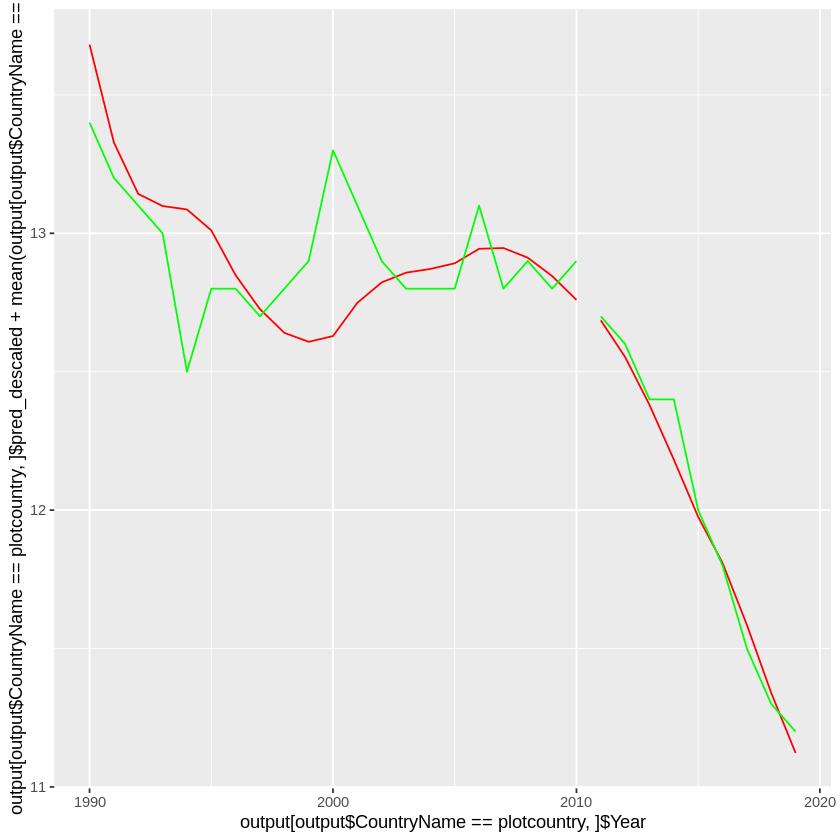

In [81]:
plotcountry='France'
ggplot()+
geom_line(aes(x=output[output$CountryName==plotcountry,]$Year, y=output[output$CountryName==plotcountry,]$pred_descaled+mean(output[output$CountryName==plotcountry,]$original)), color='red')+
geom_line(aes(x=output[output$CountryName==plotcountry,]$Year, y=output[output$CountryName==plotcountry,]$original), color='green')+
geom_line(aes(x=out[out$country==plotcountry,]$year, y=out[out$country==plotcountry,]$value), color='red')+
geom_line(aes(x=out[out$country==plotcountry,]$year, y=out[out$country==plotcountry,]$original), color='green')

In [ ]:
plotcountry='Burundi'
plotcountry2='Rwanda'
ggplot()+
geom_line(aes(x=output[output$CountryName==plotcountry,]$Year, y=output[output$CountryName==plotcountry,]$pred_descaled+mean(output[output$CountryName==plotcountry,]$original)), color='red')+
geom_line(aes(x=output[output$CountryName==plotcountry,]$Year, y=output[output$CountryName==plotcountry,]$original), color='green')+
geom_line(aes(x=out[out$country==plotcountry,]$year, y=out[out$country==plotcountry,]$value), color='red')+
geom_line(aes(x=out[out$country==plotcountry,]$year, y=out[out$country==plotcountry,]$original), color='green')+
geom_line(aes(x=output[output$CountryName==plotcountry2,]$Year, y=output[output$CountryName==plotcountry2,]$pred_descaled+mean(output[output$CountryName==plotcountry2,]$original)), color='blue')+
geom_line(aes(x=output[output$CountryName==plotcountry2,]$Year, y=output[output$CountryName==plotcountry2,]$original), color='orange')+
geom_line(aes(x=out[out$country==plotcountry2,]$year, y=out[out$country==plotcountry2,]$value), color='blue')+
geom_line(aes(x=out[out$country==plotcountry2,]$year, y=out[out$country==plotcountry2,]$original), color='orange')

### The below code attempts to evaluate the performance of the model on two elements - how well it trained and how well it tested. The unscaled values are finally returned to their original levels using an unscaling offset then the original is subtracted to create a new, completely unscaled difference. This difference is then divided by the mean of the country in question to scale the score response (differences are measured in original units so a high birthrate country could have a proportional residual with a higher absolute number) and provide a fair means of evaluation.

In [78]:
country=NULL
diff=NULL
for (x in unique(out$country)){
country=append(country, x)
diff=append(diff, sum(abs(out[out['country']==x,]$projdiff)))}
howbadp=data.frame(country=country, proj_diff=diff)
howbadp=howbadp[!howbadp$country=='',]
howbadp$proj_diff=as.double(howbadp$proj_diff)

output$offset=as.numeric('')
for (x in unique(output$CountryName)){output[output['CountryName']==x,]$offset=mean(output[output$CountryName==x,]$original)}
output$diff=abs(output$pred_descaled+output$offset-output$original)

country=NULL
diff=NULL
for (x in unique(output$CountryName)){
#     print(paste(x, sum(output[output['CountryName']==x,]$diff)))
country=append(country, x)
diff=append(diff, sum(output[output['CountryName']==x,]$diff))}
howbad=data.frame(country=country, trn_diff=diff)
howbad=howbad[!howbad$country=='',]
howbad$trn_diff=as.double(howbad$trn_diff)

howbad$ISO3=""
howbad$Region1=""
howbad$adj_proj_diff=as.numeric("")
howbad$adj_trn_diff=as.numeric("")
contdf$ISO3=as.character(contdf$ISO3)
howbad=left_join(howbad, howbadp, on='country')
for (x in unique(howbad$country)){
    howbad[howbad$country==x,]$ISO3=contdf[contdf$CountryName==x,]$ISO3[1]
    howbad[howbad$country==x,]$Region1=contdf[contdf$CountryName==x,]$Region1[1]
                                 howbad[howbad$country==x,]$adj_proj_diff=howbad[howbad$country==x,]$proj_diff/mean(contdf[contdf$CountryName==x,]$SPDYNCBRTIN)
                                 howbad[howbad$country==x,]$adj_trn_diff=howbad[howbad$country==x,]$trn_diff/mean(contdf[contdf$CountryName==x,]$SPDYNCBRTIN)
}

Joining, by = "country"


In [80]:
howbad%>%arrange(adj_proj_diff)

country,trn_diff,ISO3,Region1,adj_proj_diff,adj_trn_diff,proj_diff
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
France,3.694960,FRA,19,0.04233489,0.2922457,0.5352541
Switzerland,5.376221,CHE,19,0.15375031,0.5012014,1.6492284
Austria,10.614082,AUT,19,0.15586782,1.0488223,1.5773824
Italy,6.180689,ITA,16,0.16120276,0.6772120,1.4712439
Ireland,7.760796,IRL,11,0.28548731,0.5293858,4.1852439
Sweden,15.689597,SWE,11,0.28965004,1.3394647,3.3927674
Netherlands,10.107483,NLD,19,0.29640586,0.8705842,3.4412720
Slovenia,5.297533,SVN,16,0.29713585,0.5425947,2.9010363
Portugal,8.476044,PRT,16,0.32068819,0.8419912,3.2282611


### We then call the howbad table while sorting by the adjusted projected difference (adj_proj_diff) so the countries that modeled the best are at top and the worst at bottom. If a country performs particularly bad, this is where you consider whether they should be removed from the continent pool and the entire process restarted.

### Great models usually have adj_proj_diff under .1 , good under .5, rough under 1, pretty bad over 1. 

In [65]:
howbad%>%arrange(adj_proj_diff)

country,trn_diff,ISO3,adj_proj_diff,adj_trn_diff,proj_diff,Region1
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe
France,3.69496,FRA,0.04233489,0.2922457,0.5352541,Western Europe


In [139]:
howbad%>%arrange(adj_proj_diff)

country,trn_diff,ISO3,adj_proj_diff,adj_trn_diff,proj_diff
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
France,6.645799,FRA,0.3880949,0.5256366,4.906813
Denmark,5.014859,DNK,0.4331745,0.4263127,5.095576
Netherlands,6.289561,NLD,0.4483905,0.5417365,5.205814
Portugal,6.370812,PRT,0.4546953,0.6328621,4.577266
Switzerland,3.839689,CHE,0.4671027,0.3579573,5.010455
Slovenia,5.154737,SVN,0.4836719,0.5279690,4.722250
Austria,4.318509,AUT,0.5008113,0.4267301,5.068211
Estonia,7.705355,EST,0.5439738,0.7308273,5.735297
Norway,4.886835,NOR,0.5713913,0.3882549,7.191912


### Use this if you want to preserve the results from above but comment out when done to avoid overwriting.

In [462]:
# write.csv(howbad, "EuropeOnlyPopOnlyP90.csv")

### This is just a way to visualize the current results and see if extreme outliers exist. Regions are applied to see if any noteworthy clustering exists. If any clusters arise, they should probably be grouped if in sufficient numbers.

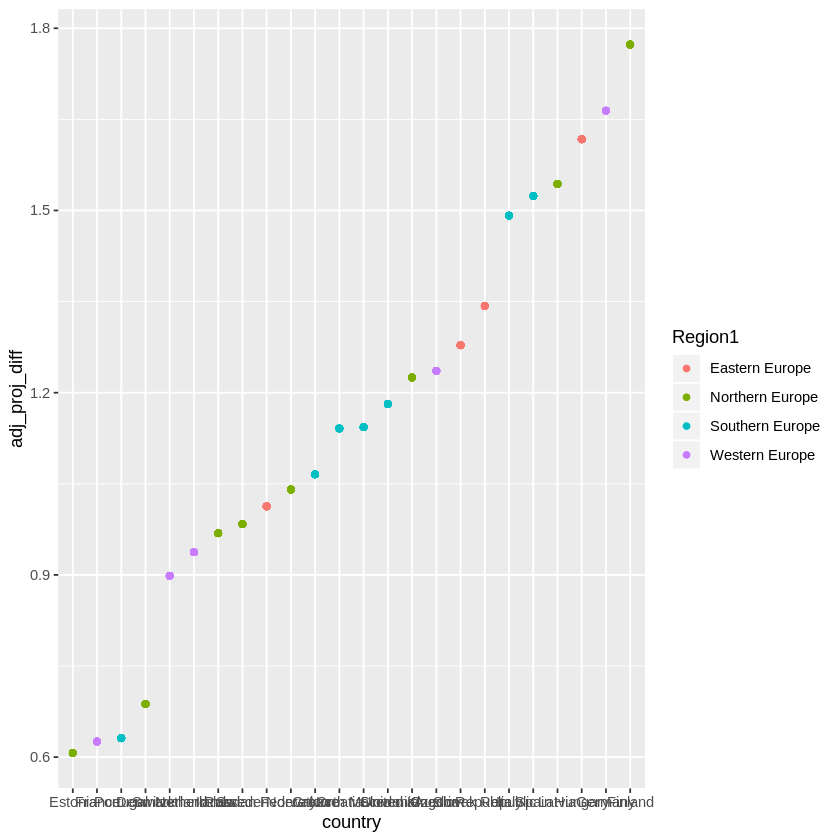

In [129]:
library(forcats)
howbad%>%mutate(country=fct_reorder(country, howbad$adj_proj_diff))%>%ggplot()+geom_point(aes(x=country, y=adj_proj_diff, color=Region1))

## Visualizing countries to see if clustering is evident

### Install and load needed packages then loading the base data into my_spdf to make spatial subsets as needed

In [149]:
install.packages('rgdal')

also installing the dependency ‘sp’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [150]:
library(rgdal)
my_spdf <- readOGR( 
  dsn= "/dsa/groups/capstonesp2022/online/group_3/map/", 
  layer="TM_WORLD_BORDERS_SIMPL-0.3",
  verbose=FALSE
)


#Region codes available here: https://unstats.un.org/unsd/methodology/m49/
#Short list: Africa:2, Americas:19, Asia:142, Europe:150, Oceania:9

Loading required package: sp
Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-29, (SVN revision 1165M)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-6


### Creating a subset for Europe (code 150) and appending ISO3 and model score values from the howbad dataframe. In the second block, the field of view and the data cuts are made then plotted.

In [599]:
Europe <- my_spdf[my_spdf@data$REGION==150 , ]
Europe@data$NAME[!Europe@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
Europe@data=left_join(Europe@data, howbad[,2:4], on=ISO3)

[1] Albania                                  
 [2] Bosnia and Herzegovina                   
 [3] Bulgaria                                 
 [4] Denmark                                  
 [5] Ireland                                  
 [6] Estonia                                  
 [7] Austria                                  
 [8] Czech Republic                           
 [9] Finland                                  
[10] France                                   
[11] Germany                                  
[12] Greece                                   
[13] Croatia                                  
[14] Hungary                                  
[15] Iceland                                  
[16] Italy                                    
[17] Latvia                                   
[18] Belarus                                  
[19] Lithuania                                
[20] Slovakia                                 
[21] Liechtenstein                            
[22] The former Yugoslav Republic of Macedonia
[23] Malta                                    
[24] Belgium                                  
[25] Faroe Islands                            
[26] Andorra                                  
[27] Gibraltar                                
[28] Isle of Man                              
[29] Luxembourg                               
[30] Monaco                                   
[31] Montenegro                               
[32] Åland Islands                            
[33] Netherlands                              
[34] Norway                                   
[35] Poland                                   
[36] Portugal                                 
[37] Romania                                  
[38] Republic of Moldova                      
[39] Russia                                   
[40] Slovenia                                 
[41] Spain                                    
[42] Sweden                                   
[43] Switzerland                              
[44] United Kingdom                           
[45] Ukraine                                  
[46] San Marino                               
[47] Serbia                                   
[48] Holy See (Vatican City)                  
[49] Svalbard                                 
[50] Guernsey                                 
[51] Jersey                                   
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Algeria                  Angola                   Benin                   
 [4] Botswana                 Burkina Faso             Burundi                 
 [7] Cabo Verde               Cameroon                 Central African Republic
[10] Chad                     Congo, Dem. Rep.         Congo, Rep.             
[13] Cote d'Ivoire            Egypt, Arab Rep.         Eswatini                
[16] Ethiopia                 Gabon                    Gambia, The             
[19] Ghana                    Guinea                   Kenya                   
[22] Lesotho                  Madagascar               Malawi                  
[25] Mali                     Mauritania               Mozambique              
[28] Namibia                  Niger                    Nigeria                 
[31] Rwanda                   Senegal                  Sierra Leone            
[34] South Africa             Sudan                    Tanzania                
[37] Togo                     Uganda                   Zambia                  
[40] Zimbabwe                
134 Levels: Albania Algeria Angola Argentina Armenia Australia ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

In [600]:
library(RColorBrewer)
my_colors <- brewer.pal(9, "Reds") 
my_colors <- colorRampPalette(my_colors)(21)
 
# Attribute the appropriate color to each country
class_of_country <- cut(Europe@data$adj_proj_diff, 21)
my_colors <- my_colors[as.numeric(class_of_country)]
 
# Make the plot

plot(Europe , xlim=c(-20,60) , ylim=c(36,70), col=my_colors ,  bg = "#A6CAE0")

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in seq.int(rx[1L], rx[2L], length.out = nb): 'from' must be a finite number


### Complete world dataframe and plot

In [117]:
Complete <- my_spdf
Complete@data$NAME[!Complete@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
Complete@data=left_join(Complete@data, howbad[,2:4], on=ISO3)

ERROR: Error in eval(expr, envir, enclos): object 'my_spdf' not found


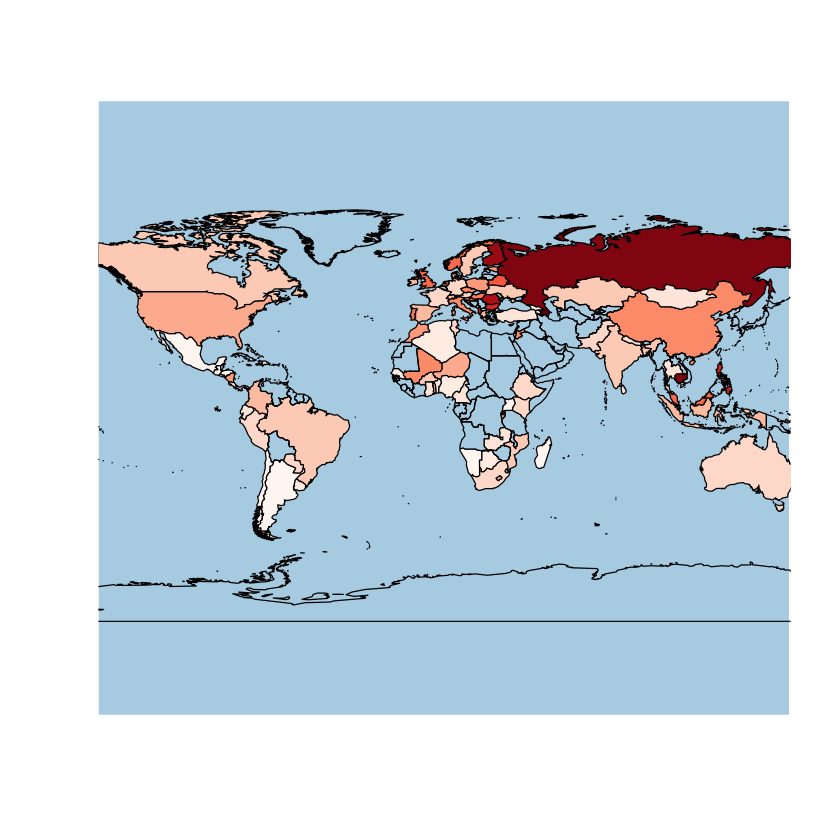

In [287]:
library(RColorBrewer)
my_colors <- brewer.pal(9, "Reds") 
my_colors <- colorRampPalette(my_colors)(21)
 
# Attribute the appropriate color to each country
class_of_country <- cut(Complete@data$adj_proj_diff, 21)
my_colors <- my_colors[as.numeric(class_of_country)]
 
# Make the plot

plot(Complete , xlim=c(-130,140) , ylim=c(-70,70), col=my_colors ,  bg = "#A6CAE0")

### South America dataframe and plot

In [238]:
SAmerica <- my_spdf[my_spdf@data$REGION==19 , ]
SAmerica@data$NAME[!SAmerica@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
SAmerica@data=left_join(SAmerica@data, howbad[,2:4], on=ISO3)

[1] Antigua and Barbuda              Argentina                       
 [3] Barbados                         Bermuda                         
 [5] Bahamas                          Belize                          
 [7] Bolivia                          Brazil                          
 [9] Canada                           Chile                           
[11] Cayman Islands                   Colombia                        
[13] Costa Rica                       Cuba                            
[15] Dominica                         Dominican Republic              
[17] Ecuador                          El Salvador                     
[19] French Guiana                    Falkland Islands (Malvinas)     
[21] Grenada                          Greenland                       
[23] Guatemala                        Guyana                          
[25] Haiti                            Honduras                        
[27] Jamaica                          Martinique                      
[29] Montserrat                       Mexico                          
[31] Aruba                            Anguilla                        
[33] Suriname                         Nicaragua                       
[35] Paraguay                         Peru                            
[37] Panama                           Puerto Rico                     
[39] Saint Kitts and Nevis            Saint Lucia                     
[41] Trinidad and Tobago              United States                   
[43] Uruguay                          Saint Vincent and the Grenadines
[45] Venezuela                        British Virgin Islands          
[47] United States Virgin Islands     Guadeloupe                      
[49] Netherlands Antilles             Saint Pierre and Miquelon       
[51] Turks and Caicos Islands         Saint Martin                    
[53] Saint Barthelemy                
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Argentina                Belize                   Brazil                  
 [4] Canada                   Chile                    Colombia                
 [7] Costa Rica               Dominican Republic       Ecuador                 
[10] El Salvador              Guatemala                Honduras                
[13] Jamaica                  Mexico                   Nicaragua               
[16] Panama                   Paraguay                 Peru                    
[19] United States of America Uruguay                 
249 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

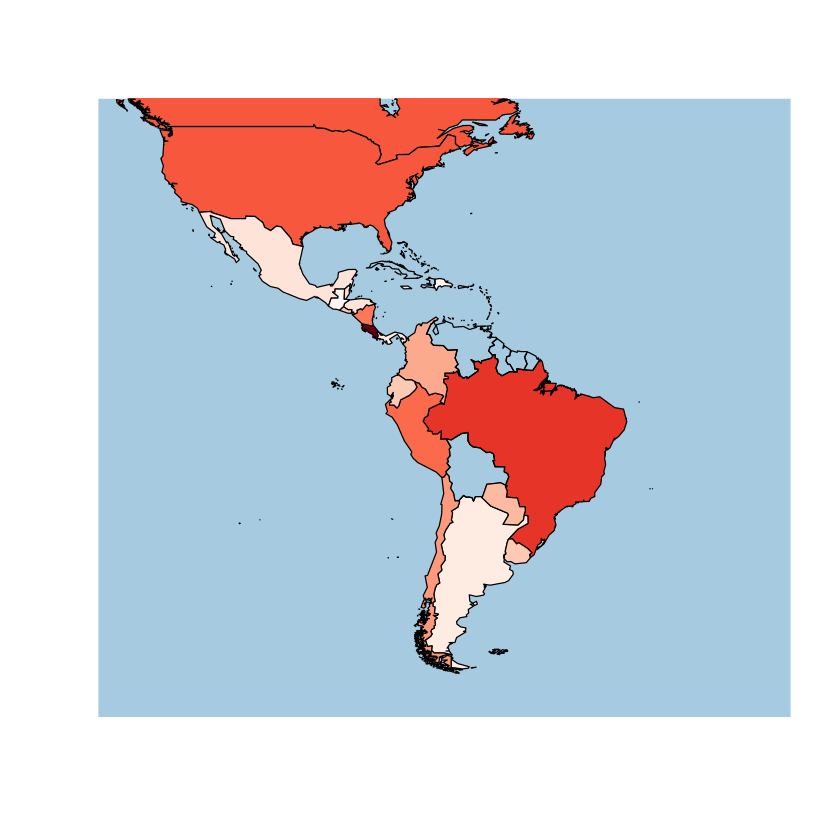

In [239]:
library(RColorBrewer)
my_colors <- brewer.pal(9, "Reds") 
my_colors <- colorRampPalette(my_colors)(21)
 
# Attribute the appropriate color to each country
class_of_country <- cut(SAmerica@data$adj_proj_diff, 21)
my_colors <- my_colors[as.numeric(class_of_country)]
 
# Make the plot

plot(SAmerica , xlim=c(-90,-50) , ylim=c(-60,50), col=my_colors ,  bg = "#A6CAE0")

### Africa dataframe and plot

In [603]:
Africa <- my_spdf[my_spdf@data$REGION==2 , ]
Africa@data$NAME[!Africa@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
Africa@data=left_join(Africa@data, howbad[,3:4], on=ISO3)

[1] Algeria                          Angola                          
 [3] Benin                            Congo                           
 [5] Democratic Republic of the Congo Burundi                         
 [7] Cameroon                         Chad                            
 [9] Comoros                          Central African Republic        
[11] Cape Verde                       Djibouti                        
[13] Egypt                            Equatorial Guinea               
[15] Eritrea                          Ethiopia                        
[17] Gambia                           Gabon                           
[19] Ghana                            Guinea                          
[21] Cote d'Ivoire                    Kenya                           
[23] Liberia                          Libyan Arab Jamahiriya          
[25] Madagascar                       Mali                            
[27] Morocco                          Mauritius                       
[29] Mauritania                       Mozambique                      
[31] Malawi                           Niger                           
[33] Mayotte                          Nigeria                         
[35] Guinea-Bissau                    Reunion                         
[37] Rwanda                           Seychelles                      
[39] South Africa                     Lesotho                         
[41] Botswana                         Senegal                         
[43] Sierra Leone                     Somalia                         
[45] Sudan                            Togo                            
[47] Sao Tome and Principe            Tunisia                         
[49] United Republic of Tanzania      Uganda                          
[51] Burkina Faso                     Namibia                         
[53] Swaziland                        Zambia                          
[55] Zimbabwe                         Saint Helena                    
[57] Western Sahara                  
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Algeria                  Angola                   Benin                   
 [4] Botswana                 Burkina Faso             Burundi                 
 [7] Cabo Verde               Cameroon                 Central African Republic
[10] Chad                     Congo, Dem. Rep.         Congo, Rep.             
[13] Cote d'Ivoire            Egypt, Arab Rep.         Eswatini                
[16] Ethiopia                 Gabon                    Gambia, The             
[19] Ghana                    Guinea                   Kenya                   
[22] Lesotho                  Madagascar               Malawi                  
[25] Mali                     Mauritania               Mozambique              
[28] Namibia                  Niger                    Nigeria                 
[31] Rwanda                   Senegal                  Sierra Leone            
[34] South Africa             Sudan                    Tanzania                
[37] Togo                     Uganda                   Zambia                  
[40] Zimbabwe                
134 Levels: Albania Algeria Angola Argentina Armenia Australia ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

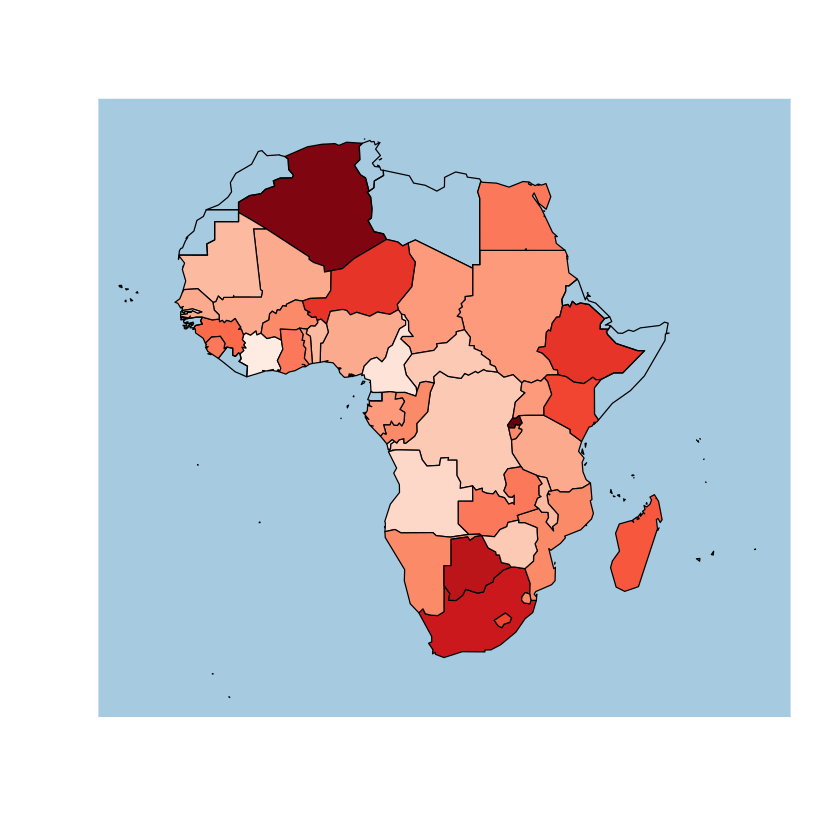

In [604]:
library(RColorBrewer)
my_colors <- brewer.pal(9, "Reds") 
my_colors <- colorRampPalette(my_colors)(21)
 
# Attribute the appropriate color to each country
class_of_country <- cut(Africa@data$adj_proj_diff, 21)
my_colors <- my_colors[as.numeric(class_of_country)]
 
# Make the plot

plot(Africa , xlim=c(-20,60) , ylim=c(-40,40), col=my_colors ,  bg = "#A6CAE0")

### Population only CSVs were generated above then loaded below and joined with their ISO3 code

In [261]:
allcsv=read.csv('AllCountriesPopOnlyNew.csv')
allcsv=allcsv[,c('country', 'adj_proj_diff', 'ISO3')]
names(allcsv)[2]='all_adj_proj_diff'
asiacsv=left_join(read.csv('AsiaOnlyPopOnlyNew.csv'), allcsv, on=country)
SAcsv=left_join(read.csv('SAOnlyPopOnlyNew.csv'), allcsv, on=country)
NAcsv=left_join(read.csv('NAOnlyPopOnlyNew.csv'), allcsv, on=country)
africacsv=left_join(read.csv('AfricaOnlyPopOnlyNew.csv'), allcsv, on=country)
europecsv=left_join(read.csv('EuropeOnlyPopOnlyNew.csv'), allcsv, on=country)


Joining, by = c("country", "ISO3")
Warning message:
“Column `country` joining factors with different levels, coercing to character vector”Warning message:
“Column `ISO3` joining factors with different levels, coercing to character vector”Joining, by = c("country", "ISO3")
Warning message:
“Column `country` joining factors with different levels, coercing to character vector”Warning message:
“Column `ISO3` joining factors with different levels, coercing to character vector”Joining, by = c("country", "ISO3")
Warning message:
“Column `country` joining factors with different levels, coercing to character vector”Warning message:
“Column `ISO3` joining factors with different levels, coercing to character vector”Joining, by = c("country", "ISO3")
Warning message:
“Column `country` joining factors with different levels, coercing to character vector”Warning message:
“Column `ISO3` joining factors with different levels, coercing to character vector”Joining, by = c("country", "ISO3")
Warning messa

### Scores were compared to see if the per-continent model score or the worldwide model score was lowest. If the continent score was lowest, the country was filled white. If the worldwide score was lowest, the country was filled red. 

In [262]:
africacsv$cont=ifelse(africacsv$adj_proj_diff<africacsv$all_adj_proj_diff, 'white', 'red')
europecsv$cont=ifelse(europecsv$adj_proj_diff<europecsv$all_adj_proj_diff, 'white', 'red')
NAcsv$cont=ifelse(NAcsv$adj_proj_diff<NAcsv$all_adj_proj_diff, 'white', 'red')
asiacsv$cont=ifelse(asiacsv$adj_proj_diff<asiacsv$all_adj_proj_diff, 'white', 'red')
SAcsv$cont=ifelse(SAcsv$adj_proj_diff<SAcsv$all_adj_proj_diff, 'white', 'red')

### Plotting the findings from above

[1] Albania                                  
 [2] Bosnia and Herzegovina                   
 [3] Bulgaria                                 
 [4] Denmark                                  
 [5] Ireland                                  
 [6] Estonia                                  
 [7] Austria                                  
 [8] Czech Republic                           
 [9] Finland                                  
[10] France                                   
[11] Germany                                  
[12] Greece                                   
[13] Croatia                                  
[14] Hungary                                  
[15] Iceland                                  
[16] Italy                                    
[17] Latvia                                   
[18] Belarus                                  
[19] Lithuania                                
[20] Slovakia                                 
[21] Liechtenstein                            
[22] The former Yugoslav Republic of Macedonia
[23] Malta                                    
[24] Belgium                                  
[25] Faroe Islands                            
[26] Andorra                                  
[27] Gibraltar                                
[28] Isle of Man                              
[29] Luxembourg                               
[30] Monaco                                   
[31] Montenegro                               
[32] Åland Islands                            
[33] Netherlands                              
[34] Norway                                   
[35] Poland                                   
[36] Portugal                                 
[37] Romania                                  
[38] Republic of Moldova                      
[39] Russia                                   
[40] Slovenia                                 
[41] Spain                                    
[42] Sweden                                   
[43] Switzerland                              
[44] United Kingdom                           
[45] Ukraine                                  
[46] San Marino                               
[47] Serbia                                   
[48] Holy See (Vatican City)                  
[49] Svalbard                                 
[50] Guernsey                                 
[51] Jersey                                   
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Argentina     Bolivia       Brazil        Chile         Colombia     
 [6] Ecuador       Guyana        Paraguay      Peru          Uruguay      
[11] Venezuela, RB
128 Levels: Albania Algeria Argentina Armenia Australia Austria ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

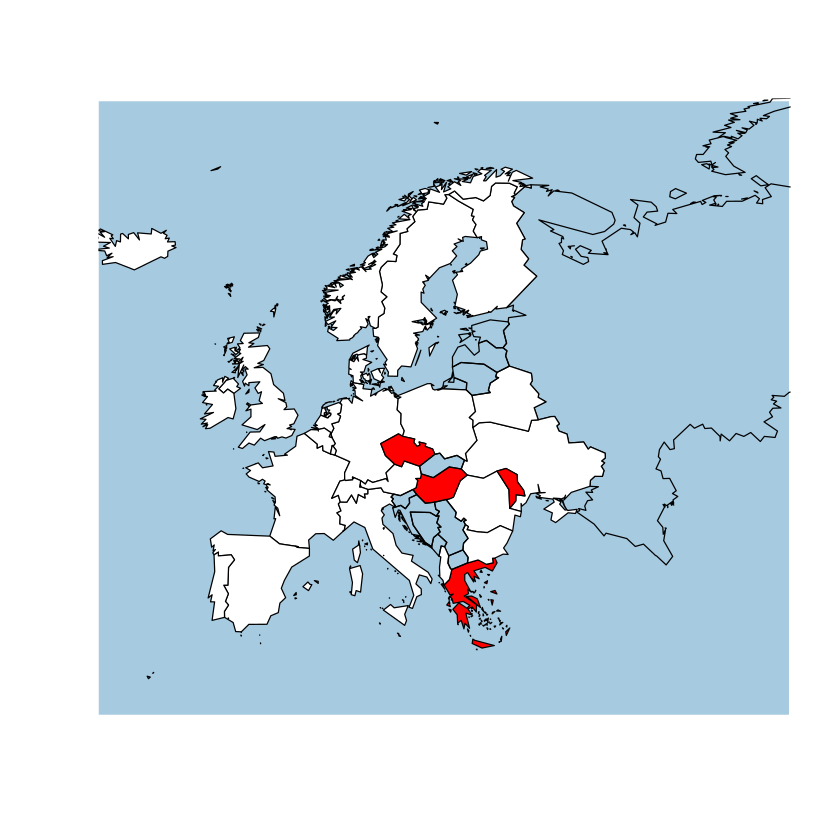

In [264]:
Europe <- my_spdf[my_spdf@data$REGION==150 , ]
Europe@data$NAME[!Europe@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
Europe@data=left_join(Europe@data, europecsv[c(4,9)], on=ISO3)
plot(Europe , xlim=c(-20,60) , ylim=c(36,70), col=Europe@data$cont ,  bg = "#A6CAE0")

[1] Algeria                          Angola                          
 [3] Benin                            Congo                           
 [5] Democratic Republic of the Congo Burundi                         
 [7] Cameroon                         Chad                            
 [9] Comoros                          Central African Republic        
[11] Cape Verde                       Djibouti                        
[13] Egypt                            Equatorial Guinea               
[15] Eritrea                          Ethiopia                        
[17] Gambia                           Gabon                           
[19] Ghana                            Guinea                          
[21] Cote d'Ivoire                    Kenya                           
[23] Liberia                          Libyan Arab Jamahiriya          
[25] Madagascar                       Mali                            
[27] Morocco                          Mauritius                       
[29] Mauritania                       Mozambique                      
[31] Malawi                           Niger                           
[33] Mayotte                          Nigeria                         
[35] Guinea-Bissau                    Reunion                         
[37] Rwanda                           Seychelles                      
[39] South Africa                     Lesotho                         
[41] Botswana                         Senegal                         
[43] Sierra Leone                     Somalia                         
[45] Sudan                            Togo                            
[47] Sao Tome and Principe            Tunisia                         
[49] United Republic of Tanzania      Uganda                          
[51] Burkina Faso                     Namibia                         
[53] Swaziland                        Zambia                          
[55] Zimbabwe                         Saint Helena                    
[57] Western Sahara                  
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Argentina     Bolivia       Brazil        Chile         Colombia     
 [6] Ecuador       Guyana        Paraguay      Peru          Uruguay      
[11] Venezuela, RB
128 Levels: Albania Algeria Argentina Armenia Australia Austria ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

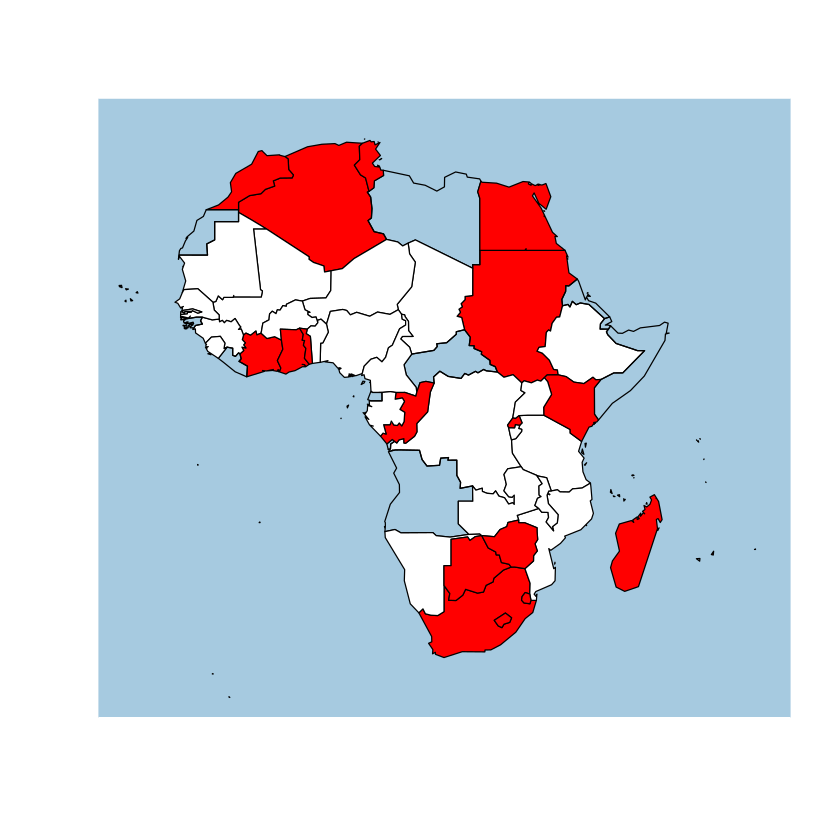

In [265]:
Africa <- my_spdf[my_spdf@data$REGION==2 , ]
Africa@data$NAME[!Africa@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
Africa@data=left_join(Africa@data, africacsv[c(4,9)], on=ISO3)
plot(Africa , xlim=c(-20,60) , ylim=c(-40,40), col=Africa@data$cont ,  bg = "#A6CAE0")

[1] Antigua and Barbuda              Argentina                       
 [3] Barbados                         Bermuda                         
 [5] Bahamas                          Belize                          
 [7] Bolivia                          Brazil                          
 [9] Canada                           Chile                           
[11] Cayman Islands                   Colombia                        
[13] Costa Rica                       Cuba                            
[15] Dominica                         Dominican Republic              
[17] Ecuador                          El Salvador                     
[19] French Guiana                    Falkland Islands (Malvinas)     
[21] Grenada                          Greenland                       
[23] Guatemala                        Guyana                          
[25] Haiti                            Honduras                        
[27] Jamaica                          Martinique                      
[29] Montserrat                       Mexico                          
[31] Aruba                            Anguilla                        
[33] Suriname                         Nicaragua                       
[35] Paraguay                         Peru                            
[37] Panama                           Puerto Rico                     
[39] Saint Kitts and Nevis            Saint Lucia                     
[41] Trinidad and Tobago              United States                   
[43] Uruguay                          Saint Vincent and the Grenadines
[45] Venezuela                        British Virgin Islands          
[47] United States Virgin Islands     Guadeloupe                      
[49] Netherlands Antilles             Saint Pierre and Miquelon       
[51] Turks and Caicos Islands         Saint Martin                    
[53] Saint Barthelemy                
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Argentina     Bolivia       Brazil        Chile         Colombia     
 [6] Ecuador       Guyana        Paraguay      Peru          Uruguay      
[11] Venezuela, RB
128 Levels: Albania Algeria Argentina Armenia Australia Austria ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

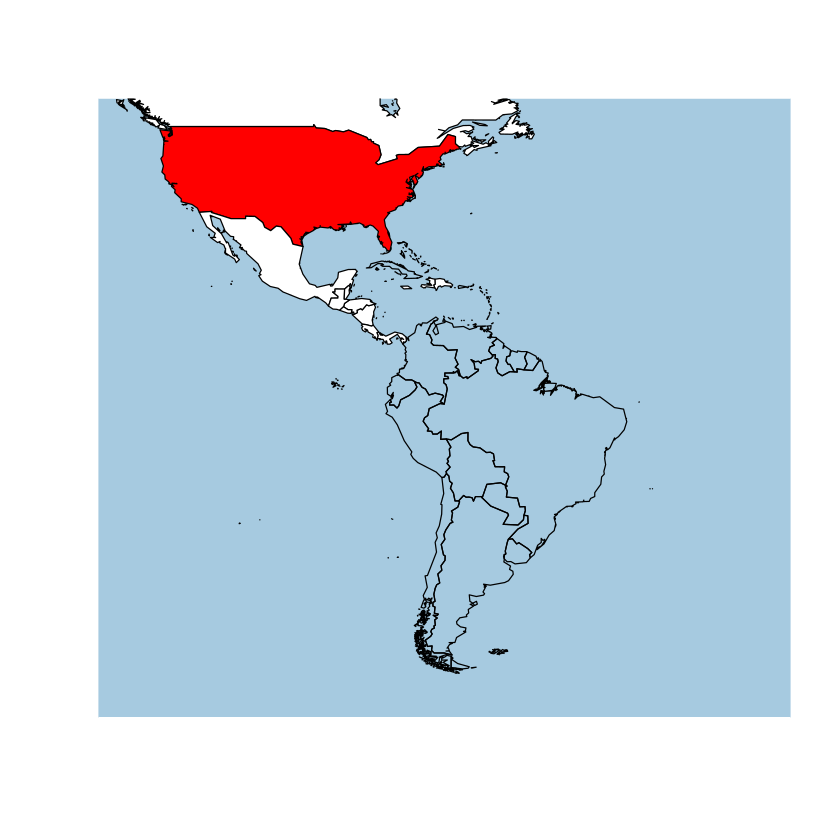

In [266]:
NAmerica <- my_spdf[my_spdf@data$REGION==19 , ]
NAmerica@data$NAME[!NAmerica@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
NAmerica@data=left_join(NAmerica@data, NAcsv[c(4,9)], on=ISO3)
plot(NAmerica , xlim=c(-90,-50) , ylim=c(-60,50), col= NAmerica@data$cont,  bg = "#A6CAE0")

[1] Antigua and Barbuda              Argentina                       
 [3] Barbados                         Bermuda                         
 [5] Bahamas                          Belize                          
 [7] Bolivia                          Brazil                          
 [9] Canada                           Chile                           
[11] Cayman Islands                   Colombia                        
[13] Costa Rica                       Cuba                            
[15] Dominica                         Dominican Republic              
[17] Ecuador                          El Salvador                     
[19] French Guiana                    Falkland Islands (Malvinas)     
[21] Grenada                          Greenland                       
[23] Guatemala                        Guyana                          
[25] Haiti                            Honduras                        
[27] Jamaica                          Martinique                      
[29] Montserrat                       Mexico                          
[31] Aruba                            Anguilla                        
[33] Suriname                         Nicaragua                       
[35] Paraguay                         Peru                            
[37] Panama                           Puerto Rico                     
[39] Saint Kitts and Nevis            Saint Lucia                     
[41] Trinidad and Tobago              United States                   
[43] Uruguay                          Saint Vincent and the Grenadines
[45] Venezuela                        British Virgin Islands          
[47] United States Virgin Islands     Guadeloupe                      
[49] Netherlands Antilles             Saint Pierre and Miquelon       
[51] Turks and Caicos Islands         Saint Martin                    
[53] Saint Barthelemy                
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Argentina     Bolivia       Brazil        Chile         Colombia     
 [6] Ecuador       Guyana        Paraguay      Peru          Uruguay      
[11] Venezuela, RB
128 Levels: Albania Algeria Argentina Armenia Australia Austria ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

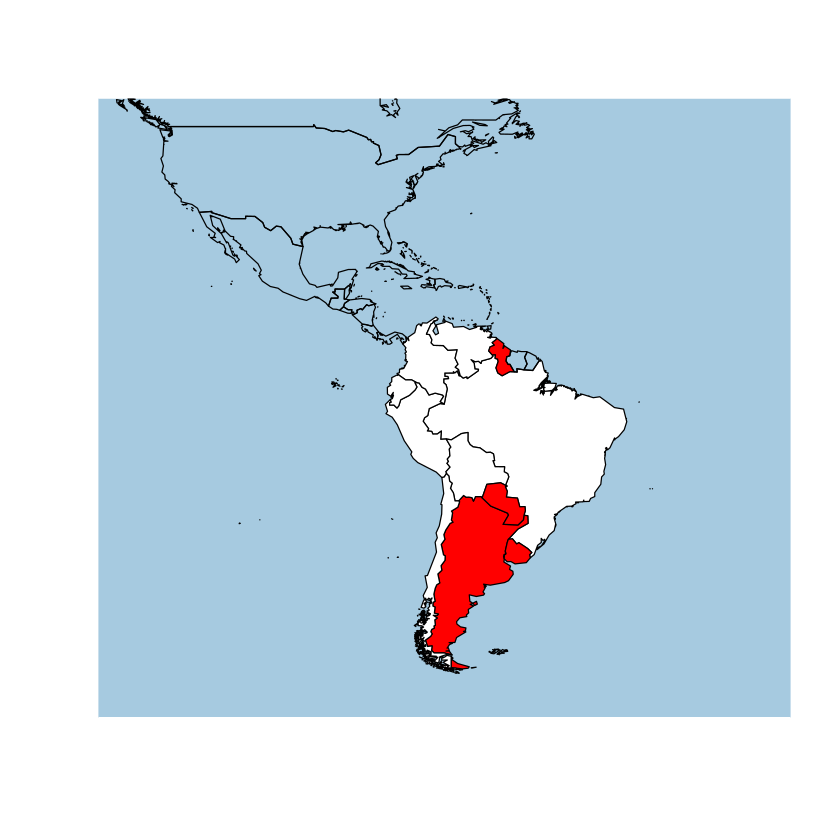

In [267]:
SAmerica <- my_spdf[my_spdf@data$REGION==19 , ]
SAmerica@data$NAME[!SAmerica@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
SAmerica@data=left_join(SAmerica@data, SAcsv[c(4,9)], on=ISO3)
plot(SAmerica , xlim=c(-90,-50) , ylim=c(-60,50), col= SAmerica@data$cont,  bg = "#A6CAE0")

[1] Azerbaijan                            
 [2] Armenia                               
 [3] Bahrain                               
 [4] Bangladesh                            
 [5] Burma                                 
 [6] Brunei Darussalam                     
 [7] Cambodia                              
 [8] Sri Lanka                             
 [9] China                                 
[10] Afghanistan                           
[11] Bhutan                                
[12] Cyprus                                
[13] Georgia                               
[14] India                                 
[15] Iran (Islamic Republic of)            
[16] Israel                                
[17] Iraq                                  
[18] Japan                                 
[19] Jordan                                
[20] Kyrgyzstan                            
[21] Korea, Democratic People's Republic of
[22] Korea, Republic of                    
[23] Kuwait                                
[24] Kazakhstan                            
[25] Lao People's Democratic Republic      
[26] Lebanon                               
[27] Mongolia                              
[28] Oman                                  
[29] Maldives                              
[30] Malaysia                              
[31] Hong Kong                             
[32] Macau                                 
[33] Palestine                             
[34] Nepal                                 
[35] Pakistan                              
[36] Qatar                                 
[37] Philippines                           
[38] Saudi Arabia                          
[39] Singapore                             
[40] Syrian Arab Republic                  
[41] Thailand                              
[42] Tajikistan                            
[43] Turkey                                
[44] Turkmenistan                          
[45] Uzbekistan                            
[46] Viet Nam                              
[47] Yemen                                 
[48] Indonesia                             
[49] United Arab Emirates                  
[50] Timor-Leste                           
246 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

[1] Argentina     Bolivia       Brazil        Chile         Colombia     
 [6] Ecuador       Guyana        Paraguay      Peru          Uruguay      
[11] Venezuela, RB
128 Levels: Albania Algeria Argentina Armenia Australia Austria ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factor and character vector, coercing into character vector”

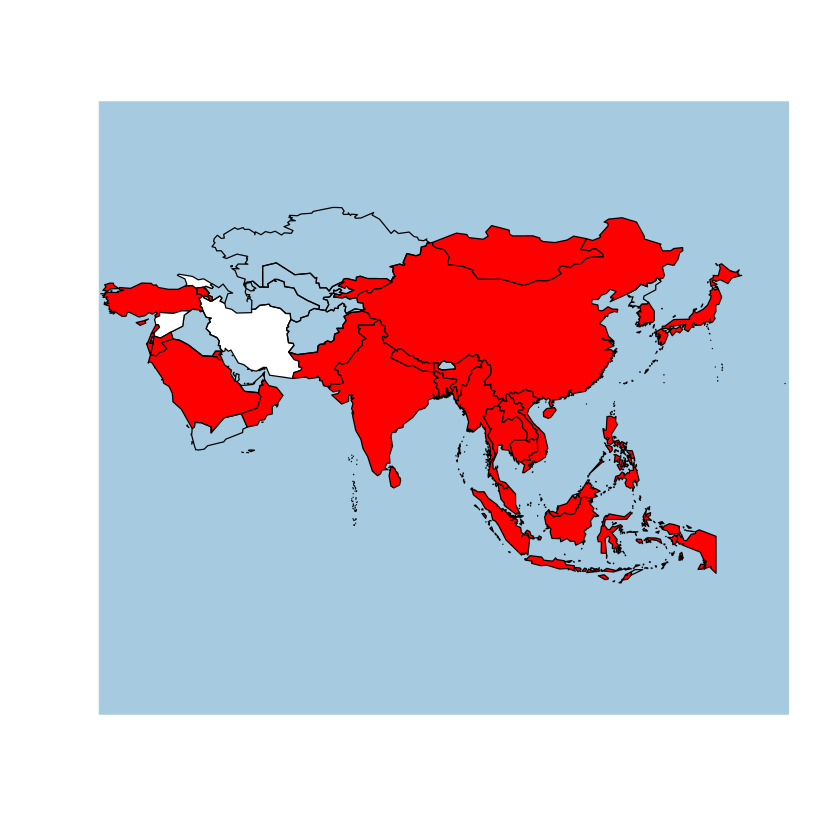

In [268]:
Asia <- my_spdf[my_spdf@data$REGION==142 , ]
Asia@data$NAME[!Asia@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
Asia@data=left_join(Asia@data, asiacsv[c(4,9)], on=ISO3)
plot(Asia , xlim=c(30,150) , ylim=c(-0,40), col=Asia@data$cont ,  bg = "#A6CAE0")

### Below, we calculated the worldwide model mean score then filled those countries less than the mean as white. Those higher than the mean are red. This is effectively the same as above except on a world model so those that performed best on a continent model show poorly on this version.

In [270]:
allcsv$abvmean=ifelse(allcsv$all_adj_proj_diff<.45, 'white', 'red')

[1] Antigua and Barbuda                      
  [2] Algeria                                  
  [3] Azerbaijan                               
  [4] Albania                                  
  [5] Armenia                                  
  [6] Angola                                   
  [7] American Samoa                           
  [8] Argentina                                
  [9] Australia                                
 [10] Bahrain                                  
 [11] Barbados                                 
 [12] Bermuda                                  
 [13] Bahamas                                  
 [14] Bangladesh                               
 [15] Belize                                   
 [16] Bosnia and Herzegovina                   
 [17] Bolivia                                  
 [18] Burma                                    
 [19] Benin                                    
 [20] Solomon Islands                          
 [21] Brazil                                   
 [22] Bulgaria                                 
 [23] Brunei Darussalam                        
 [24] Canada                                   
 [25] Cambodia                                 
 [26] Sri Lanka                                
 [27] Congo                                    
 [28] Democratic Republic of the Congo         
 [29] Burundi                                  
 [30] China                                    
 [31] Afghanistan                              
 [32] Bhutan                                   
 [33] Chile                                    
 [34] Cayman Islands                           
 [35] Cameroon                                 
 [36] Chad                                     
 [37] Comoros                                  
 [38] Colombia                                 
 [39] Costa Rica                               
 [40] Central African Republic                 
 [41] Cuba                                     
 [42] Cape Verde                               
 [43] Cook Islands                             
 [44] Cyprus                                   
 [45] Denmark                                  
 [46] Djibouti                                 
 [47] Dominica                                 
 [48] Dominican Republic                       
 [49] Ecuador                                  
 [50] Egypt                                    
 [51] Ireland                                  
 [52] Equatorial Guinea                        
 [53] Estonia                                  
 [54] Eritrea                                  
 [55] El Salvador                              
 [56] Ethiopia                                 
 [57] Austria                                  
 [58] Czech Republic                           
 [59] French Guiana                            
 [60] Finland                                  
 [61] Fiji                                     
 [62] Falkland Islands (Malvinas)              
 [63] Micronesia, Federated States of          
 [64] French Polynesia                         
 [65] France                                   
 [66] Gambia                                   
 [67] Gabon                                    
 [68] Georgia                                  
 [69] Ghana                                    
 [70] Grenada                                  
 [71] Greenland                                
 [72] Germany                                  
 [73] Guam                                     
 [74] Greece                                   
 [75] Guatemala                                
 [76] Guinea                                   
 [77] Guyana                                   
 [78] Haiti                                    
 [79] Honduras                                 
 [80] Croatia                                  
 [81] Hungary                                  
 [82] Iceland                                  
 [83] India                                    
 [84] Iran (Islami

[1] Argentina     Bolivia       Brazil        Chile         Colombia     
 [6] Ecuador       Guyana        Paraguay      Peru          Uruguay      
[11] Venezuela, RB
128 Levels: Albania Algeria Argentina Armenia Australia Austria ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factors with different levels, coercing to character vector”

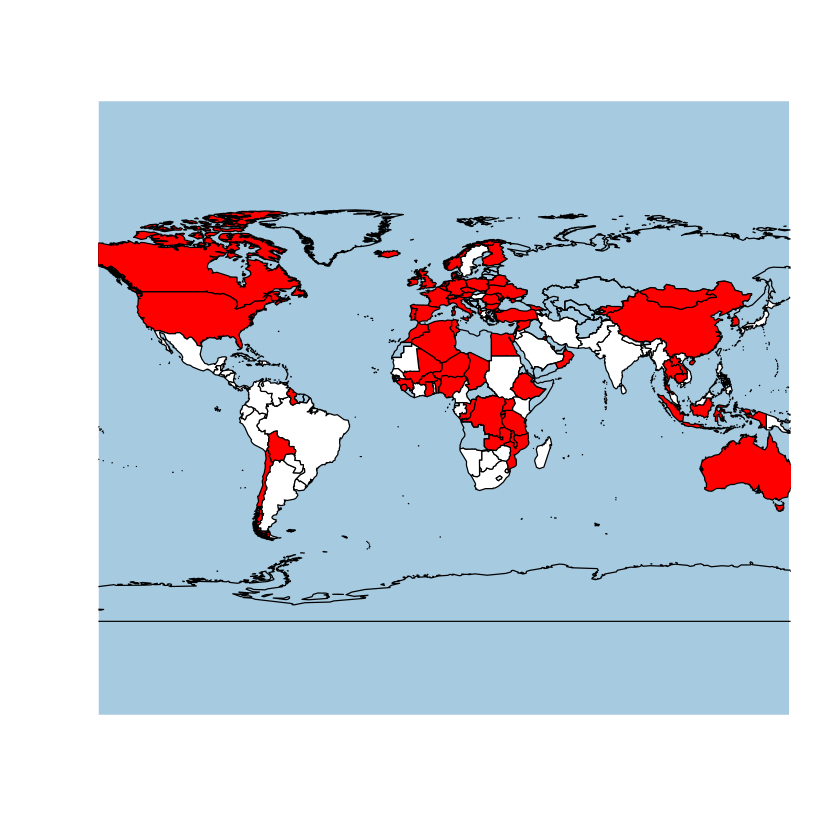

In [271]:
All <- my_spdf
All@data$NAME[!All@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
All@data=left_join(All@data, allcsv[c(3,4)], on=ISO3)
plot(All , xlim=c(-130,140) , ylim=c(-70,70), col=All@data$abvmean ,  bg = "#A6CAE0")

### Not sure what I hoped to see here but this is turning the 47 best scores white and the other half red

In [173]:
allcsv$abvmed='red'
allcsv=allcsv%>%arrange(all_adj_proj_diff)
allcsv$abvmed[1:47]="white"


[1] Antigua and Barbuda                      
  [2] Algeria                                  
  [3] Azerbaijan                               
  [4] Albania                                  
  [5] Armenia                                  
  [6] Angola                                   
  [7] American Samoa                           
  [8] Argentina                                
  [9] Australia                                
 [10] Bahrain                                  
 [11] Barbados                                 
 [12] Bermuda                                  
 [13] Bahamas                                  
 [14] Bangladesh                               
 [15] Belize                                   
 [16] Bosnia and Herzegovina                   
 [17] Bolivia                                  
 [18] Burma                                    
 [19] Benin                                    
 [20] Solomon Islands                          
 [21] Brazil                                   
 [22] Bulgaria                                 
 [23] Brunei Darussalam                        
 [24] Canada                                   
 [25] Cambodia                                 
 [26] Sri Lanka                                
 [27] Congo                                    
 [28] Democratic Republic of the Congo         
 [29] Burundi                                  
 [30] China                                    
 [31] Afghanistan                              
 [32] Bhutan                                   
 [33] Chile                                    
 [34] Cayman Islands                           
 [35] Cameroon                                 
 [36] Chad                                     
 [37] Comoros                                  
 [38] Colombia                                 
 [39] Costa Rica                               
 [40] Central African Republic                 
 [41] Cuba                                     
 [42] Cape Verde                               
 [43] Cook Islands                             
 [44] Cyprus                                   
 [45] Denmark                                  
 [46] Djibouti                                 
 [47] Dominica                                 
 [48] Dominican Republic                       
 [49] Ecuador                                  
 [50] Egypt                                    
 [51] Ireland                                  
 [52] Equatorial Guinea                        
 [53] Estonia                                  
 [54] Eritrea                                  
 [55] El Salvador                              
 [56] Ethiopia                                 
 [57] Austria                                  
 [58] Czech Republic                           
 [59] French Guiana                            
 [60] Finland                                  
 [61] Fiji                                     
 [62] Falkland Islands (Malvinas)              
 [63] Micronesia, Federated States of          
 [64] French Polynesia                         
 [65] France                                   
 [66] Gambia                                   
 [67] Gabon                                    
 [68] Georgia                                  
 [69] Ghana                                    
 [70] Grenada                                  
 [71] Greenland                                
 [72] Germany                                  
 [73] Guam                                     
 [74] Greece                                   
 [75] Guatemala                                
 [76] Guinea                                   
 [77] Guyana                                   
 [78] Haiti                                    
 [79] Honduras                                 
 [80] Croatia                                  
 [81] Hungary                                  
 [82] Iceland                                  
 [83] India                                    
 [84] Iran (Islami

[1] Armenia     Azerbaijan  Bangladesh  Cambodia    China       Cyprus     
 [7] Georgia     India       Indonesia   Israel      Jordan      Kazakhstan 
[13] Malaysia    Mongolia    Nepal       Pakistan    Philippines Sri Lanka  
[19] Thailand    Turkey     
249 Levels: Afghanistan Åland Islands Albania Algeria American Samoa ... Zimbabwe

Joining, by = "ISO3"
Warning message:
“Column `ISO3` joining factors with different levels, coercing to character vector”

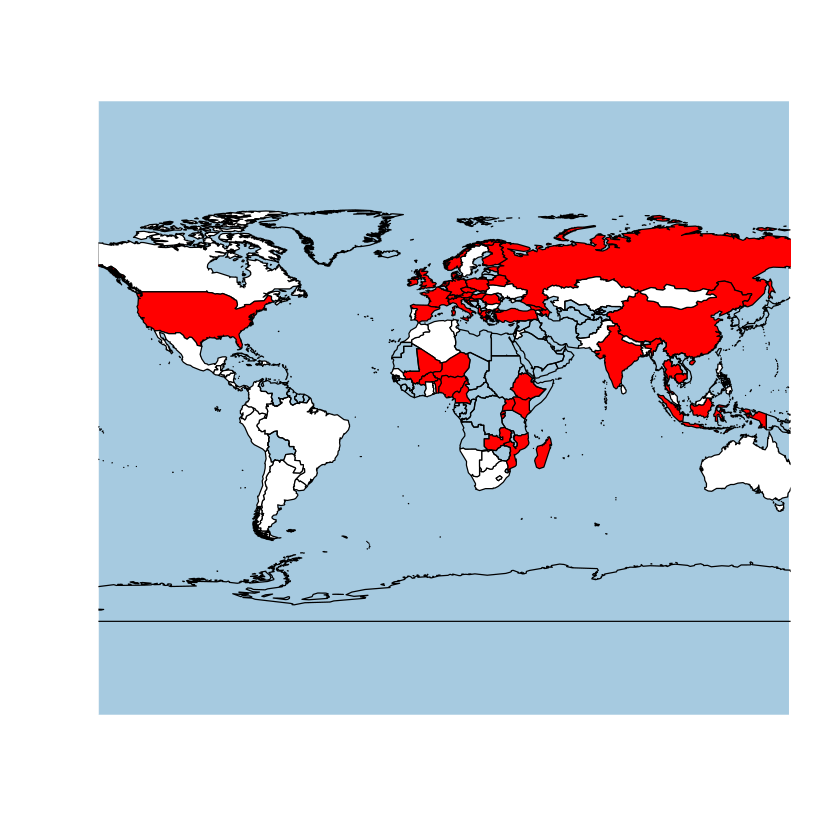

In [174]:
All2 <- my_spdf
All2@data$NAME[!All2@data$ISO3 %in% unique(output$ISO3)]
unique(output$CountryName)
All2@data=left_join(All2@data, allcsv[c(3,5)], on=ISO3)
plot(All2 , xlim=c(-130,140) , ylim=c(-70,70), col=All2@data$abvmed ,  bg = "#A6CAE0")

### This was just to test the above methods of model evaluation on three scenarios: Our original, cut down dataframe; our full dataframe going back to 1970; and our full dataframe from 1990 forward. The full dataframe from 1990 forward performs best.

In [330]:
all1=read.csv('AllCountriesOnlyPop.csv')
all1$ISO3=as.character(all1$ISO3)
names(all1)[5]='all1_adj_proj_diff'
all2=read.csv('AllCountriesPopOnlyNew.csv')
all2$ISO3=as.character(all2$ISO3)
names(all2)[5]='all2_adj_proj_diff'
all3=read.csv('AllCountriesPopOnlyP90.csv')
all3$ISO3=as.character(all3$ISO3)
names(all3)[5]='all3_adj_proj_diff'
allcomb=inner_join(all1, all2, by='ISO3')
allcomb=inner_join(allcomb, all3, by='ISO3')
#allcomb
allcomb=allcomb[,c('country.x', 'all1_adj_proj_diff', 'all2_adj_proj_diff', 'all3_adj_proj_diff')]

In [335]:
allcomb$best=ifelse(allcomb$all1_adj_proj_diff<allcomb$all2_adj_proj_diff, ifelse(allcomb$all1_adj_proj_diff<allcomb$all3_adj_proj_diff, "all1", "all3"), ifelse(allcomb$all2_adj_proj_diff<allcomb$all3_adj_proj_diff, 'all2', 'all3'))

In [337]:
allcomb%>%group_by(best)%>%summarize(n())

best,n()
<chr>,<int>
all1,32
all2,20
all3,35


In [338]:
allcomb

country.x,all1_adj_proj_diff,all2_adj_proj_diff,all3_adj_proj_diff,best
<fct>,<dbl>,<dbl>,<dbl>,<chr>
Albania,0.48521576,0.68915376,0.58821028,all1
Algeria,0.19942491,0.57173724,0.20290535,all1
Argentina,0.08038964,0.09499617,0.08607923,all1
Armenia,0.18755410,0.27000351,0.34002643,all1
Australia,0.43910721,0.52387032,0.52811567,all1
Austria,0.63367220,0.69109234,0.42157677,all3
Bangladesh,0.28245246,0.29974619,0.23840956,all3
Belarus,0.67676333,0.74913213,0.67080830,all3
Belize,0.11474159,0.20521792,0.11511064,all1


### These calculations are preserved below just to illustrate how the existing scale function calculates and, thus, how to undo said scaling. These are incoporated into the existing calculations above. The first block is if centering occurs (adjusting based on mean) and the second is if only scaling occurs. Calculations are not provided for a centering without a scaling.

In [558]:
output$SOsolcent=(completeDF$SPDYNCBRTIN-mean(completeDF$SPDYNCBRTIN))/sd(completeDF$SPDYNCBRTIN)
output$oremake=(output$SOsol*sd(completeDF$SPDYNCBRTIN))+mean(completeDF$SPDYNCBRTIN)

In [224]:
output$SOsoluncent=(completeDF$SPDYNCBRTIN)/(sqrt(sum(completeDF$SPDYNCBRTIN^2)/(length(completeDF$SPDYNCBRTIN)-1)))
output$oremake=(output$SOsoluncent*(sqrt(sum(completeDF$SPDYNCBRTIN^2)/(length(completeDF$SPDYNCBRTIN)-1))))

In [559]:
#output$wtf=output$SPDYNCBRTIN*sd(completeDF$SPDYNCBRTIN)+mean(completeDF$SPDYNCBRTIN)
head(output)

Year,CountryName,SPDYNCBRTIN,pred,pred_descaled,original,SOsolcent,oremake
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1990,Albania,0.20728899,0.2618950,3.031282,24.867,0.20728899,24.867
1991,Albania,0.15354978,0.2808240,3.250373,24.245,0.15354978,24.245
1992,Albania,0.09168921,0.2623894,3.037004,23.529,0.09168921,23.529
1993,Albania,0.02369442,0.2141457,2.478611,22.742,0.02369442,22.742
1994,Albania,-0.04887943,0.1579323,1.827974,21.902,-0.04887943,21.902
1995,Albania,-0.12508198,0.1154830,1.336648,21.020,-0.12508198,21.020
